In [ ]:
!ls

sample_data


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!clear
!echo welcome

!rm -f spark-3.3.[01]-bin-hadoop3.tgz* 
!rm -rf spark-3.3.[01]-bin-hadoop3

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz

!ls -alt
print("standalone Spark is now installed")

welcome
--2023-05-15 10:04:04--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  12.1MB/s    in 26s     

2023-05-15 10:04:31 (11.1 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

total 292368
drwxr-xr-x  1 root root      4096 May 15 10:04 .
drwxr-xr-x  1 root root      4096 May 15 09:59 ..
drwxr-xr-x  1 root root      4096 May 11 16:35 sample_data
drwxr-xr-x  4 root root      4096 May 11 16:34 .config
-rw-r--r--  1 root root 299360284 Feb 10 21:28 spark-3.3.2-bin-hadoop3.tgz
drwxr-xr-x 13  501 1000      4096 Feb 10 20:40 spark-3.3.2-bin-hadoop3
standal

In [ ]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
!pip3 install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
SparkSession.builder.getOrCreate()
## 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The zipped TFL data file is obtained using the wget and is unqipped

In [ ]:
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

--2023-05-15 10:04:51--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.101.13, 104.16.100.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.101.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   250MB/s    in 0.9s    

2023-05-15 10:04:52 (250 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

# Reading in and Filtering the Data

The research hypothesis is " In 2014 people ride longer in Autumn than in Spring". To be able to test this hypothesis, definitions for the time period that spans autumn and spring must be made. The Met Office meteorologically as the 1st March to the 31st May (https://blog.metoffice.gov.uk/2014/03/05/spring-has-sprung/). This time period is covered by files: 3,4,5, and parts of files 2 and 6. September to November is defined as the autumnal months by the met office (https://blog.metoffice.gov.uk/2014/12/31/2014-a-year-in-weather/). This time period is covered by files: 9b, 10a, 10b, 11a, 11b, and part of files 12a and 12b.

In [ ]:
spark = SparkSession.builder.appName("bikes").getOrCreate()
Spring_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(['./2*csv','./3*csv','./4*csv', './5*csv','./6*csv']))  # 03 Feb 14 to 21 June 14

Autumn_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(['./9b*csv','./10a*csv','./10b*csv', './11a*csv','./11b*csv','./12a*csv','./12b*csv']))  # 01 Sep 14 to 06 Dec 14

As highlighted above, the files read include dates outside of the defined time period of spring. The data can be filtered to remove rows of rides outisde of the spring time period.

In [ ]:
Spring_df.show(10)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name| _c9|_c10|_c11|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+
| 33253206|    1140|  11439|27/05/2014 00:59|          695|Islington Green, ...|27/05/2014 00:40|             81|Great Titchfield ...|null|null|null|
| 33345935|     660|  10792|30/05/2014 18:00|          326|Graham Street, Angel|30/05/2014 17:49|            203|West Smithfield R...|null|null|null|
| 33480171|    1440|  11901|03/06/2014 13:29|          695|Islington Green, ...|03/06/2014 13:05|            239|Warren Street Sta...|null|null|null|
| 33709780|     960|   6891|09/06/2014 18:31|           20|Drummond Street ,...|09/06/2014 18:15|   

The start date column can be converted to expected timestamp format. This allows for rows not within the specified time period to be filtered out.

In [ ]:
# convert the "Start Date" column to a timestamp and alias it as "start"
Spring_df = Spring_df.withColumn("start", to_timestamp(col("Start Date"), format='dd/MM/yyyy HH:mm'))

# filter rows with start date before March 1st 2014
Spring_df.filter(col("start") < "2014-03-01 00:00:00").show(5)

Spring_df.filter(col("start") > "2014-06-01 00:00:00").show(5)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+-------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name| _c9|_c10|_c11|              start|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+-------------------+
| 30286260|    1260|  12218|03/02/2014 23:24|          697|Charlotte Terrace...|03/02/2014 23:03|            311|Foley Street, Fit...|null|null|null|2014-02-03 23:03:00|
| 30341088|    1020|   9215|05/02/2014 23:24|          697|Charlotte Terrace...|05/02/2014 23:07|             81|Great Titchfield ...|null|null|null|2014-02-05 23:07:00|
| 30368838|    1500|    204|06/02/2014 23:28|          695|Islington Green, ...|06/02/2014 23:03|            311|Foley Street, Fit...|null|null|null|2

In [ ]:
Spring_df = Spring_df.filter(col("start") >= "2014-03-01 00:00:00")
Spring_df = Spring_df.filter(col("start") <= "2014-05-31 23:59:59")

The rows have been filtered out.

In [ ]:
Spring_df.filter(col("start") < "2014-03-01 00:00:00").show(5)
Spring_df.filter(col("start") > "2014-06-31 00:00:00").show(5)

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|_c9|_c10|_c11|start|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|_c9|_c10|_c11|start|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
+---------+--------+-------+--------+-------------+---------------+-

A similar process can be followed for the autumn data

In [ ]:
# convert the "Start Date" column to a timestamp and alias it as "start"
Autumn_df = Autumn_df.withColumn("start", to_timestamp(col("Start Date"), format='dd/MM/yyyy HH:mm'))

In [ ]:
# filter rows with start date before March 1st 2014
Autumn_df.filter(col("start") < "2014-09-01 00:00:00").show(5)

Autumn_df.filter(col("start") > "2014-12-01 00:00:00").show(5)

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|_c9|_c10|_c11|start|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+-------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name| _c9|_c10|_c11|              start|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------

In [ ]:
Autumn_df = Autumn_df.filter(col("start") >= "2014-09-01 00:00:00")
Autumn_df = Autumn_df.filter(col("start") <= "2014-12-01 00:00:00")

In [ ]:
Autumn_df.filter(col("start") < "2014-09-01 00:00:00").show(5)

Autumn_df.filter(col("start") > "2014-12-01 00:00:00").show(5)

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|_c9|_c10|_c11|start|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|_c9|_c10|_c11|start|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+---+----+----+-----+
+---------+--------+-------+--------+-------------+---------------+-

# Data Inspection and Understanding

In [ ]:
print(f"There are  {Spring_df.count()} rows in the spring data set and there are {Autumn_df.count()} rows in the autumn data set.")
print(f" There are {Autumn_df.count() - Spring_df.count()} more rows in the autumn data set than the spring data set.")

There are  2424933 rows in the spring data set and there are 2648354 rows in the autumn data set.
 There are 223421 more rows in the autumn data set than the spring data set.


A look at the unique values in the `_c9`, `_c10`, and `_c11` columns in both the spring and autumn show that the columns contained no useful infomation. Therefore, the columns can be dropped from the data sets.

In [ ]:
Spring_df[["_c9", "_c10", "_c11"]].distinct().show()

+----+----+----+
| _c9|_c10|_c11|
+----+----+----+
|null|null|null|
+----+----+----+



In [ ]:
Autumn_df[["_c9", "_c10", "_c11"]].distinct().show()

+----+----+----+
| _c9|_c10|_c11|
+----+----+----+
|null|null|null|
+----+----+----+



In [ ]:
Spring_df = Spring_df.drop('_c9', '_c10', '_c11')
Autumn_df = Autumn_df.drop('_c9', '_c10', '_c11')

A look at the remaining columns shows that there are 10 columns in both data sets. The columns are:


*   Rental Id - Unique Identifier of the bike rental
*   Duration - The duration of the bike rental in seconds
*   Bike Id - The ID of the bike that has been rented
*   End Date - The date when the rental ended
*   EndStation ID - The ID of the station where the rental ended
*   EndStation Name - The name of the station where the rental ended
*   Start Date - The date when the rental started
*   StartStation Id - The ID of the station where the rental started
*   StartStation Name - The name of the station where the rental started
*   Start - The timestamp transformed start date



In [ ]:
print(Spring_df.columns)
print(Autumn_df.columns)
print(len(Spring_df.columns))
print(len(Autumn_df.columns))

['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id', 'EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name', 'start']
['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id', 'EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name', 'start']
10
10


In [ ]:
print((Spring_df.select("Rental Id").distinct().count()/Spring_df.count()))
print((Autumn_df.select("Rental Id").distinct().count()/Autumn_df.count())) 

1.0
1.0


In [ ]:
Spring_df.printSchema()
Autumn_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- start: timestamp (nullable = true)

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- start: timestamp (nullable = true)



The Duration column is converted to integer type

In [ ]:
Spring_df = Spring_df.withColumn("Duration", Spring_df["Duration"].cast(IntegerType()))
Autumn_df = Autumn_df.withColumn("Duration", Autumn_df["Duration"].cast(IntegerType()))

In [ ]:
Spring_df.printSchema()
Autumn_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- start: timestamp (nullable = true)

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- start: timestamp (nullable = true)



In [ ]:
Spring_df.show(5)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+-------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|              start|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+-------------------+
| 33253206|    1140|  11439|27/05/2014 00:59|          695|Islington Green, ...|27/05/2014 00:40|             81|Great Titchfield ...|2014-05-27 00:40:00|
| 33345935|     660|  10792|30/05/2014 18:00|          326|Graham Street, Angel|30/05/2014 17:49|            203|West Smithfield R...|2014-05-30 17:49:00|
| 33385892|    1560|   6172|31/05/2014 19:10|          430|South Parade, Che...|31/05/2014 18:44|            286|St. John's Wood R...|2014-05-31 18:44:00|
| 33340654|    1380|   9506|30/05/2014 16:19|           86|Sancroft St

# Data Processing

Missing values, outliers

## Missing Values

The below code returns the nan and null values in each column. There are only 20 bike rides in the spring data set that have a null or nan value, with 20 rides having null or nan values in the `Endstation Id` and `EndStation Name` variables. There are no null or nan values in the autumn data set.

In [ ]:
Spring_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Spring_df.drop('start').columns]).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|        0|       0|      0|       0|           20|             20|         0|              0|                0|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+



In [ ]:
Autumn_df.select([count(when(isnan(c), c)).alias(c) for c in Autumn_df.drop('start').columns]).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|        0|       0|      0|       0|            0|              0|         0|              0|                0|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+



Looking at the bike rentals with null values in the endstation ID & Name columns, there does not seem to be any correlation between the bike rentals. In this research, an ANOVA statistical test will be used to test for a significant difference in the duration of bike rides between the spring and autumn time periods. Therefore the rentals with null values are removed from the data set.

In [ ]:
Spring_df.filter((isnan(col("EndStation Id")) | col("EndStation Name").isNull())).show()

+---------+--------+-------+----------------+-------------+---------------+----------------+---------------+--------------------+-------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|EndStation Name|      Start Date|StartStation Id|   StartStation Name|              start|
+---------+--------+-------+----------------+-------------+---------------+----------------+---------------+--------------------+-------------------+
| 33215283|     660|   8081|25/05/2014 13:35|         null|           null|25/05/2014 13:24|            218|St. Luke's Church...|2014-05-25 13:24:00|
| 33198434|     720|   4209|24/05/2014 17:56|         null|           null|24/05/2014 17:44|            680|Westbridge Road, ...|2014-05-24 17:44:00|
| 32826965|    1380|   5309|14/05/2014 14:08|         null|           null|14/05/2014 13:45|            190|Rampayne Street, ...|2014-05-14 13:45:00|
| 32743434|    1680|    351|11/05/2014 12:40|         null|           null|11/05/2014 12:12|        

In [ ]:
Spring_df = Spring_df.dropna()

In [ ]:
Spring_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Spring_df.drop('start').columns]).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|        0|       0|      0|       0|            0|              0|         0|              0|                0|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+



## Outliers

To be able to suitably test the project hypothesis, an establishment of what a valid bike ride needs to be defined. Bike rides that last in excess of a day can be questioned as valid rides whilst rides that last an incredibly small amount of time could be rides that have been mistakenly rented. To detect outliers, the Inter Quartile Range is used (IQR). The 25th and 75th percentiles of the duration column are first detected.

In [ ]:
Spring_df.select("Duration").summary("25%", "75%").show()

+-------+--------+
|summary|Duration|
+-------+--------+
|    25%|     480|
|    75%|    1320|
+-------+--------+



In [ ]:
Autumn_df.select("Duration").summary("25%", "75%").show()

+-------+--------+
|summary|Duration|
+-------+--------+
|    25%|     480|
|    75%|    1260|
+-------+--------+



The IQR can be calculated by finding the difference between the 75th and 25th percentiles

In [ ]:
Spring_Q1 = Spring_df.approxQuantile("Duration",[0.25],relativeError=0)
print(Spring_Q1)
Spring_Q3 = Spring_df.approxQuantile("Duration",[0.75],relativeError=0)
print(Spring_Q3)
Autumn_Q1 = Autumn_df.approxQuantile("Duration",[0.25],relativeError=0)
print(Autumn_Q1)
Autumn_Q3 = Autumn_df.approxQuantile("Duration",[0.75],relativeError=0)
print(Autumn_Q3)

[480.0]
[1320.0]
[480.0]
[1260.0]


In [ ]:
Spring_IQR = Spring_Q3[0]-Spring_Q1[0]
print(Spring_IQR)
Autumn_IQR = Autumn_Q3[0]-Autumn_Q1[0]
print(Autumn_IQR)

840.0
780.0


The upper bound is calculated. The lower bound calculated is negative and therefore not appropriate to be used. Instead the lower bound can be set as 0 so that all bike rides that are greater than 0 seconds in duration are kept. 

In [ ]:
spring_upbound = Spring_Q3[0] + 1.5 * Spring_IQR
spring_lowbound = 30

In [ ]:
autumn_upbound = Autumn_Q3[0] + 1.5 * Autumn_IQR
autumn_lowbound = 30

In [ ]:
Spring = Spring_df.filter(
    (Spring_df.Duration > spring_lowbound) & (Spring_df.Duration < spring_upbound)
)

In [ ]:
Autumn = Autumn_df.filter(
    (Autumn_df.Duration > autumn_lowbound) & (Autumn_df.Duration < autumn_upbound)
)

# Data Analysis

## Aggregation

Statistics relating to the duration of cycle rides can be found using aggregation. The average ride duration during spring is more than 30 seconds higher.

In [ ]:
avg_spring_dur = Spring.agg(avg("Duration"))
avg_spring_dur.show()

avg_autumn_dur = Autumn.agg(avg("Duration"))
avg_autumn_dur.show()

+-----------------+
|    avg(Duration)|
+-----------------+
|883.7517930339344|
+-----------------+

+-----------------+
|    avg(Duration)|
+-----------------+
|848.8046536859737|
+-----------------+



In [ ]:
Spring_StartStation_counts = Spring.groupBy("StartStation Name").count()

Spring_sts = Spring.groupBy("StartStation Name").agg(
    sum("Duration").alias("Sum of Bike Ride Durations"),
    avg("Duration").alias("Average Bike Ride Duration"),
    min("Duration").alias("Minimum Bike Ride Duration"),
    max("Duration").alias("Maximum Bike Ride Duration")
)

In [ ]:
Spring_Starts = Spring_sts.join(
    Spring_StartStation_counts, on=["StartStation Name"], how="inner").orderBy(
        "count", ascending = False)
Spring_Starts.show(5)

+--------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----+
|   StartStation Name|Sum of Bike Ride Durations|Average Bike Ride Duration|Minimum Bike Ride Duration|Maximum Bike Ride Duration|count|
+--------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----+
|Belgrove Street ,...|                  17426820|         840.6164680912643|                       120|                      2520|20731|
|Waterloo Station ...|                  14433840|          793.984267561472|                        60|                      2520|18179|
|Hyde Park Corner,...|                  22664040|        1323.8341121495328|                        60|                      2520|17120|
|Black Lion Gate, ...|                  16869720|        1208.9522717500358|                       120|                      2520|13954|
|Albert Gate, Hyde...|                  1

In [ ]:
Autumn_StartStation_counts = Autumn.groupBy("StartStation Name").count()

Autumn_sts = Autumn.groupBy("StartStation Name").agg(
    sum("Duration").alias("Sum of Bike Ride Durations"),
    avg("Duration").alias("Average Bike Ride Duration"),
    min("Duration").alias("Minimum Bike Ride Duration"),
    max("Duration").alias("Maximum Bike Ride Duration")
)

In [ ]:
Autumn_Starts = Autumn_sts.join(
    Autumn_StartStation_counts, on=["StartStation Name"], how="inner").orderBy(
        "count", ascending = False)
Autumn_Starts.show(5)

+--------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----+
|   StartStation Name|Sum of Bike Ride Durations|Average Bike Ride Duration|Minimum Bike Ride Duration|Maximum Bike Ride Duration|count|
+--------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----+
|Belgrove Street ,...|                  18290640|         822.8278375095596|                       120|                      2400|22229|
|Waterloo Station ...|                  16038420|         777.4695816568908|                        60|                      2400|20629|
|Hyde Park Corner,...|                  18853020|         1253.191970220686|                        60|                      2400|15044|
|Waterloo Station ...|                  11319480|         784.4407484407484|                        60|                      2400|14430|
|Wormwood Street, ...|                  1

In [ ]:
Autumn.describe("Duration").show()
Spring.describe("Duration").show()

+-------+-----------------+
|summary|         Duration|
+-------+-----------------+
|  count|          2483021|
|   mean|848.8046536859737|
| stddev|489.6076303550688|
|    min|               60|
|    max|             2400|
+-------+-----------------+

+-------+-----------------+
|summary|         Duration|
+-------+-----------------+
|  count|          2232250|
|   mean|883.7517930339344|
| stddev|520.0603982176281|
|    min|               60|
|    max|             2520|
+-------+-----------------+



# Exploratory Data Analysis using Matplotlib

In [ ]:
#Create a pandas df of the duration times for both the Spring and Autumn Time periods

Spring_pd = Spring[['Duration']].toPandas()
Autumn_pd = Autumn[['Duration']].toPandas()

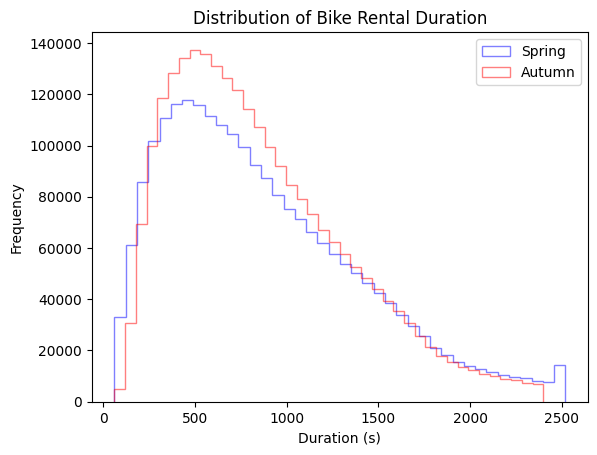

In [ ]:
plt.hist(Spring_pd, bins = 40, alpha = 0.5, label = 'Spring', color = 'blue',  histtype='step', fill = False)
plt.hist(Autumn_pd, bins = 40, alpha = 0.5, label = 'Autumn', color = 'red',  histtype='step', fill = False)
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.title("Distribution of Bike Rental Duration")
plt.legend()
plt.savefig("BikeDistribution.jpeg")

# Statistical Testing

In [ ]:
# Merge both Dfs into one DF

Spring = Spring.withColumn("Season", lit("Spring"))
Autumn = Autumn.withColumn("Season", lit("Autumn"))


df = Spring.union(Autumn)

In [ ]:
df.show(5)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+-------------------+------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|              start|Season|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+-------------------+------+
| 33253206|    1140|  11439|27/05/2014 00:59|          695|Islington Green, ...|27/05/2014 00:40|             81|Great Titchfield ...|2014-05-27 00:40:00|Spring|
| 33345935|     660|  10792|30/05/2014 18:00|          326|Graham Street, Angel|30/05/2014 17:49|            203|West Smithfield R...|2014-05-30 17:49:00|Spring|
| 33385892|    1560|   6172|31/05/2014 19:10|          430|South Parade, Che...|31/05/2014 18:44|            286|St. John's Wood R...|2014-05-31 18:44:00|Spring|
| 33340654|    1380|   9506|

In [ ]:
df.groupBy("Season").count().show()

+------+-------+
|Season|  count|
+------+-------+
|Spring|2232250|
|Autumn|2483021|
+------+-------+



In [ ]:
import scipy.stats as stats

In [ ]:
df_pd = df[['Duration', 'Season']].toPandas()

In [ ]:
df_pd.head()

,Duration,Season
0,1140,Spring
1,660,Spring
2,1560,Spring
3,1380,Spring
4,1620,Spring


The One-Way ANOVA test (from SCIPY.STATS) is used to conduct a one-way anova test to test for significance between the durations of autumn and sprinig. The test shows that there is a statistically significant difference between the groups with a p value of 0. However, whilst there is statistical significance, there is no measure on the size of that significance. 

In [ ]:
stats.f_oneway(df_pd['Duration'][df_pd['Season'] == 'Spring'],
               df_pd['Duration'][df_pd['Season'] == 'Autumn'])

F_onewayResult(statistic=5646.013974371388, pvalue=0.0)